# Creación de varios modelos de Deep Learning utilizando distintos modelos para analizar lesiones cutáneas y diagnosticarlas
## Autor: Rubén Cerezo
### Objetivos

- Preprocesar correctamente datos tabulares y de imágenes

- Construir un modelo tabular

- Construir una CNN

- Construir un modelo Early Fusion y Late Fusion

- Evaluar los modelos y compararlos

- Extraer conclusiones



El objetivo de este trabajo consiste en resolver un problema del mundo real empleando para 
ello técnicas vistas durante las sesiones de dicho módulo. En concreto, se trabajará en 
predecir la condición médica sufrida por una cohorte de pacientes a partir de las diferentes 
fuentes de información disponibles (imágenes y datos tabulares). 

Vamos a comenzar con el hito 1 de la tarea, el cual es: 
Modelo 1D (tabular): Resolver el problema considerando únicamente la información 
presente en los datos tabulares (sexo, edad, parte del cuerpo)

In [26]:
#El primer punto es instalar las librerías necesarias:
!pip install pandas 
!pip install scikit-learn
!pip install tensorflow
!pip install matplotlib
!pip install seaborn
!pip install keras
!pip install numpy
!pip install opencv-python
!pip install torch
!pip install torchvision


In [27]:
# Dado que tengo una GPU NVIDIA, instalo PyTorch con soporte CUDA para hacer pruebas con esta GPU:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [28]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

2.9.1+cpu
None
False


In [29]:
!pip install gdown 

In [30]:
!gdown --folder https://drive.google.com/drive/folders/1qTxGaojM2eJn0SpHJl2Ujk4zvDkkadPR -O data

Processing file 1n7UewGksx3UZjn34-Q1QJtLXMMp42O_0 HAM10000_metadata.csv
Processing file 1sBEsgtYVo4X7APfg-_miZvpMttfS3eJ4 hnmist_28_28_RGB.csv


Retrieving folder contents
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1n7UewGksx3UZjn34-Q1QJtLXMMp42O_0
To: c:\Users\rammu\Documents\projects\Deeplearning\practica\Deeplearning-\data\HAM10000_metadata.csv

  0%|          | 0.00/563k [00:00<?, ?B/s]
 93%|█████████▎| 524k/563k [00:00<00:00, 3.82MB/s]
100%|██████████| 563k/563k [00:00<00:00, 4.08MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sBEsgtYVo4X7APfg-_miZvpMttfS3eJ4
To: c:\Users\rammu\Documents\projects\Deeplearning\practica\Deeplearning-\data\hnmist_28_28_RGB.csv

  0%|          | 0.00/91.8M [00:00<?, ?B/s]
  1%|          | 524k/91.8M [00:00<00:23, 3.84MB/s]
  2%|▏         | 1.57M/91.8M [00:00<00:15, 5.83MB/s]
  3%|▎         | 2.62M/91.8M [00:00<00:13, 6.40MB/s]
  4%|▍         | 3.67M/91.8M [00:00<00:13, 6.45MB/s]
  5%|▌         | 4.72M/91.8M [00:00<00:12, 6.92MB/s]
  6%|▋         | 5.77M/91.8M [00:00<00:1

In [31]:
import os

# Ver qué hay dentro de la carpeta 'data'
for root, dirs, files in os.walk("data"):
    level = root.replace("data", "").count(os.sep)
    indent = " " * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files:  
        print(f"{subindent}{f}")

data/
    HAM10000_metadata.csv
    hnmist_28_28_RGB.csv


In [32]:
#Para comenzar, carguemos los datos tabulares utilizando pandas:
import pandas as pd

df = pd.read_csv(r"C:\Users\rammu\Documents\projects\Deeplearning\practica\Deeplearning-\data\HAM10000_metadata.csv")
print(df.head())
df.info()
df.head()
df.describe(include="all")
df.isna().sum()
print(df['dx'].value_counts())  # Para ver cuántas muestras hay de cada enfermedad

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
dx
nv       6705
mel      1113
bkl      1099
bcc 

El primer paso sería crear un diccionario de columnas:
| Columna      | Descripción                                                             |
| ------------ | ----------------------------------------------------------------------- |
| lesion_id    | Identificador único de la lesión                                        |
| image_id     | Identificador único de la imagen asociada a la lesión                   |
| dx           | Diagnóstico de la lesión (código de enfermedad, ej. nv, mel, bkl, etc.) |
| dx_type      | Tipo de diagnóstico (ej. histopatológico, clínico, confocal)            |
| age          | Edad del paciente en años                                               |
| sex          | Sexo del paciente (male/female/unknown)                                 |
| localization | Localización de la lesión en el cuerpo                                  |
| dataset      | Conjunto de datos de origen de la imagen/lesión                         |

Tras observar el dataset, también hacemos una pequeña observación de las enfermedades estudiadas, para lo cual creamos el siguiente "diccionario", añadiendo el número de casos en cada uno


| Enfermedad                           | Descripción                                           | Código | Nº de casos |
|-------------------------------------|------------------------------------------------------|--------|------------|
| Actinic keratoses y carcinoma de células escamosas | Tipo de cáncer de piel                                | akiec  | 327        |
| Nevus melanocítico                   | Lesión benigna común                                  | nv     | 6705       |
| Melanoma                             | Tipo de cáncer de piel agresivo                       | mel    | 1113       |
| Lesiones benignas de queratosis      | Incluyen lentigo solar y queratosis seborreica       | bkl    | 1099       |
| Dermatofibroma                        | Lesión benigna del tejido fibroso                     | df     | 115        |
| Vasculares                            | Lesiones vasculares como hemangiomas                 | vasc   | 142        |
| Lesión de células basales             | Un tipo de cáncer de piel menos agresivo que el melanoma | bcc    | 514        |


In [33]:
#Esta celda contiene todo el preproceamiento necesario para las imágenes y las etiquetas, y es la que copiaremos 

# Esta celda contiene todo el preprocesamiento necesario para las imágenes y las etiquetas
import os
import glob
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Cargar datos de imágenes desde CSV
path = r"C:\Users\rammu\Documents\projects\Deeplearning\practica\Deeplearning-\data\hnmist_28_28_RGB.csv"
df = pd.read_csv(path)
print("Columnas del dataset:", df.columns[:10])

# Cargar metadata
metadata = pd.read_csv(r"C:\Users\rammu\Documents\projects\Deeplearning\data\metadata\HAM10000_metadata.csv")

# Etiquetas
y = metadata['dx'].values[:len(df)]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)
num_classes = y_onehot.shape[1]

# Preprocesamiento tabular
tabular_data = metadata[['age', 'sex', 'localization']][:len(df)]
tabular_data = pd.get_dummies(tabular_data, columns=['sex', 'localization'], drop_first=True)
tabular_data['age'] = tabular_data['age'] / tabular_data['age'].max()
X_tab = tabular_data.values.astype(np.float32)

# Preprocesamiento imágenes
X_img = df.values.astype(np.float32).reshape(-1, 28, 28, 3)
X_img /= 255.0

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_img, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Clases:", le.classes_)

Columnas del dataset: Index(['pixel0000', 'pixel0001', 'pixel0002', 'pixel0003', 'pixel0004',
       'pixel0005', 'pixel0006', 'pixel0007', 'pixel0008', 'pixel0009'],
      dtype='object')
Train set: (8012, 28, 28, 3) (8012, 7)
Test set: (2003, 28, 28, 3) (2003, 7)
Clases: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


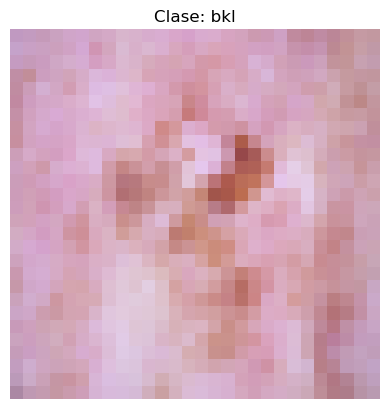

In [34]:
#comprobamos una imagen al azar
import matplotlib.pyplot as plt

# Elegimos el índice de la imagen que queremos mostrar
idx = 0  # por ejemplo, la primera imagen

# Mostramos la imagen
plt.imshow(X_img[idx])
plt.title(f"Clase: {le.classes_[y_encoded[idx]]}")
plt.axis('off')
plt.show()


| **Columna**    | **Tipo** | **Descripción**                                                                                                                                             |
| -------------- | -------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `age`          | `int`    | Edad del paciente (valores imputados con la mediana y redondeados).                                                                                         |
| `sex`          | `object` | Sexo del paciente. Puede tomar los valores: `male`, `female` o `unknown`. *(Pendiente de codificar a numérico si el modelo lo requiere)*                    |
| `localization` | `object` | Localización anatómica de la lesión (por ejemplo, `back`, `trunk`, `lower extremity`, etc.). *(Pendiente de codificar a numérico si el modelo lo requiere)* |
| `akiec`     | `float`  | Variable binaria (One-Hot) que indica si la lesión es **Actinic keratoses / intraepithelial carcinoma (akiec)**.                                            |
| `bcc`       | `float`  | Variable binaria (One-Hot) que indica si la lesión es **Basal cell carcinoma (bcc)**.                                                                       |
| `bkl`       | `float`  | Variable binaria (One-Hot) que indica si la lesión es **Benign keratosis-like lesions (bkl)**.                                                              |
| `df`        | `float`  | Variable binaria (One-Hot) que indica si la lesión es **Dermatofibroma (df)**.                                                                              |
| `mel`       | `float`  | Variable binaria (One-Hot) que indica si la lesión es **Melanoma (mel)**.                                                                                   |
| `nv`        | `float`  | Variable binaria (One-Hot) que indica si la lesión es **Melanocytic nevi (nv)**.                                                                            |
| `vasc`      | `float`  | Variable binaria (One-Hot) que indica si la lesión es **Vascular lesions (vasc)**.                                                                          |


Train set: (8012, 17) (8012, 7)
Test set: (2003, 17) (2003, 7)
Clases: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


C:\Users\rammu\AppData\Local\Temp\ipykernel_22780\373640937.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata['age'].fillna(metadata['age'].median(), inplace=True)
c:\Users\rammu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,463 (13.53 KB)

 Trainable params: 3,463 (13.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6355 - loss: 1.2249 - val_accuracy: 0.6881 - val_loss: 0.9490
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6823 - loss: 1.0070 - val_accuracy: 0.6987 - val_loss: 0.9173
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6886 - loss: 0.9887 - val_accuracy: 0.7006 - val_loss: 0.9014
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6918 - loss: 0.9702 - val_accuracy: 0.7043 - val_loss: 0.8946
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6904 - loss: 0.9683 - val_accuracy: 0.7024 - val_loss: 0.8946
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6943 - loss: 0.9579 - val_accuracy: 0.7012 - val_loss: 0.8891
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6934 - loss: 0.9558 - val_accuracy: 0.7043 - val_loss: 0.8846
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6968 - loss: 0.9486 - val_accuracy: 0.

Test accuracy: 0.6985


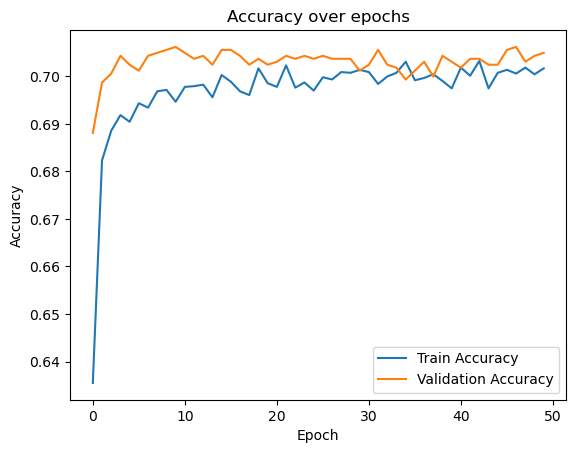

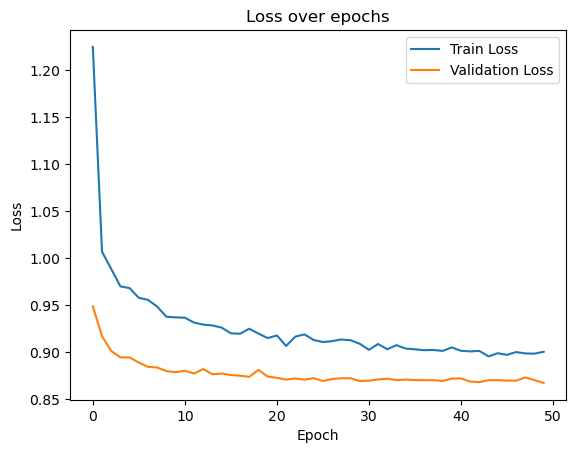

In [35]:
#Dado que vamos a hacer un modelo de clasificación sólo con datos tabulares, no queremos realizar en esta celda
#el preprocesamiento de las imágenes, así que a continuación está el código modificado para incluir sólo los datos tabulares
import os
import glob
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# Cargamos metadata
metadata = pd.read_csv(r"C:\Users\rammu\Documents\projects\Deeplearning\data\metadata\HAM10000_metadata.csv")
# Imputar nulos en 'age' 
metadata['age'].fillna(metadata['age'].median(), inplace=True)
metadata['age'] = metadata['age'].round().astype(int)
X = pd.get_dummies(metadata[['age',
    'sex', 'localization']], drop_first=True)
scaler = StandardScaler()
X['age'] = scaler.fit_transform(X[['age']])

# Codificar labels
y = metadata['dx']  # columna con las etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Dividir en train/test 

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Clases:", label_encoder.classes_)
# Ahora X_train y X_test contienen sólo los datos tabulares preprocesados
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])
# Compilar 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
model.summary()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
# Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32
)

# Evaluación
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")
#Graficamos los resultados de accuracy y loss
import matplotlib.pyplot as plt
#guardamos el modelo 
model.save('tabular_model.h5')
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Conclusiones del modelo tabular

Vemos que este modelo es muy limitado, ya que su precisión es aproximadamente de 0.69%. Esto es de esperar, ya que utiliza sólo metadatos de la lesión (la localización de la lesión, edad del paciente y su sexo), no la imagen real. Sin embargo, podría ser un buen punto de entrada para plantear un modelo Early o Late fusion donde utilicemos estos datos con un peso menor para ayudar a nuestras redes a entender mejor los datos de las imágenes. Además, nos sirve para comparar con los modelos basados sólo en imágenes y observar su efectividad
Además, como podemos ver en los gráficos, a partir de la epoch 10 conseguimos una efectividad bastante estable, por lo que probablemente limitar las epoch a 10 habría sido un buen movimiento (no lo hacemos porque al ser sólo metadatos, nuestras cpus y gpus ) hacen este trabajo con relativa facilidad y no nos supone mucho más tiempo)

C:\Users\rammu\AppData\Local\Temp\ipykernel_22780\3786884997.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata['age'].fillna(metadata['age'].median(), inplace=True)
100%|██████████| 5000/5000 [00:14<00:00, 348.98it/s]
C:\Users\rammu\AppData\Local\Temp\ipykernel_22780\3786884997.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate obj

Train set: (4000, 96, 96, 3) (4000, 7)
Test set: (1000, 96, 96, 3) (1000, 7)
Clases: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


100%|██████████| 5000/5000 [00:14<00:00, 353.95it/s]
c:\Users\rammu\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train set: (4000, 96, 96, 3) (4000, 7)
Test set: (1000, 96, 96, 3) (1000, 7)
Clases: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5625 - loss: 4.2419 - val_accuracy: 0.6837 - val_loss: 1.0355
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6778 - loss: 1.1400 - val_accuracy: 0.6837 - val_loss: 0.9625
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6828 - loss: 1.1590 - val_accuracy: 0.6837 - val_loss: 0.9903
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6866 - loss: 1.1501 - val_accuracy: 0.6837 - val_loss: 1.1021
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6869 - loss: 1.1158 - val_accuracy: 0.6837 - val_loss: 0.9465
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6869 - loss: 1.0322 - val_accuracy: 0.6837 - val_loss: 0.9656
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6869 - loss: 1.0405 - val_accuracy: 0.6837 

Test accuracy: 0.6860


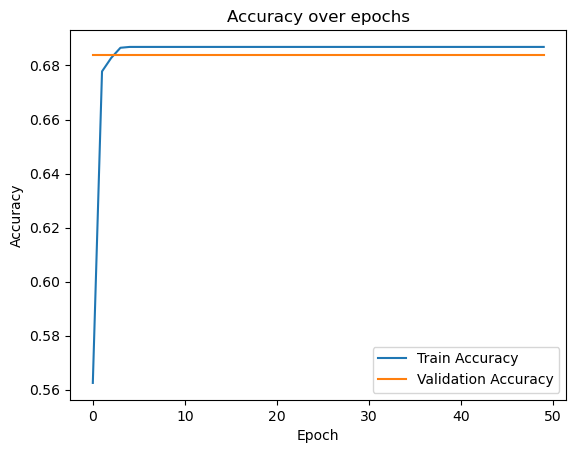

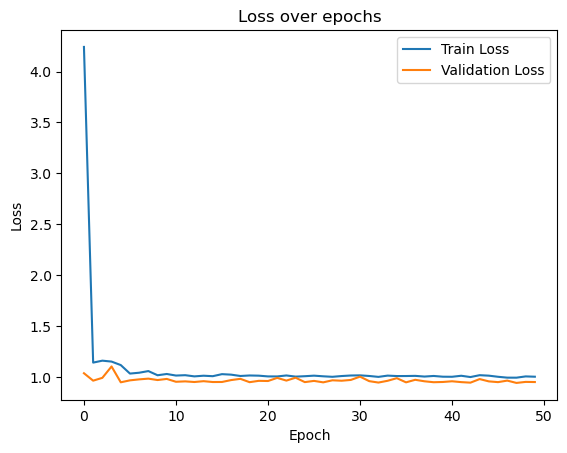

In [36]:
#Admito que primero hice este modelo, con datos de imágenes que he pasado a "churro" para hacer una red neuronal densa, como las primeras que hemos hecho en clase,
# y después me di cuenta e hice el verdadero hito 1 (que es el modelo anterior). Igualmente, lo he mantenido en el archivo porque me llevó tiempo de hacer, y me hizo ilusión que le pegaras una vuelta :)
#Después de haber hecho la carga y preprocesamiento de las imágenes, podemos proceder a construir y entrenar un modelo de red neuronal simple utilizando TensorFlow y Keras.
# Repetimos la carga de librerías necesarias y la preparación de datos como parte de las buenas prácticas de Deeplearning (hacer todo el proceso en una misma celda)

import os
import glob
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# cargamos los metadatos 
metadata = pd.read_csv(r"C:\Users\rammu\Documents\projects\Deeplearning\data\metadata\HAM10000_metadata.csv")

# Imputar nulos en 'age' si lo quieres usar más adelante
metadata['age'].fillna(metadata['age'].median(), inplace=True)
metadata['age'] = metadata['age'].round().astype(int)

# Cargar imágenes 
img_folder = r"C:\Users\rammu\Documents\projects\Deeplearning\data\HAM10000_images"
list_imgs = glob.glob(os.path.join(img_folder, "*.jpg"))

height, width, channels = 96, 96, 3
n_images = len(list_imgs)
images = np.zeros((n_images, height, width, channels), dtype=np.float32)
labels = []

for i, img_path in enumerate(tqdm(list_imgs)):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: {img_path} could not be loaded.")
        continue
    img = cv2.resize(img, (width, height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    images[i] = img

    # Extraer etiqueta desde metadata
    img_id = os.path.basename(img_path).replace(".jpg", "")
    label = metadata.loc[metadata["image_id"] == img_id, "dx"].values[0]
    labels.append(label)

#  Convertir labels a one-hot 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_onehot = to_categorical(y_encoded)

# Dividir en train/test 
X_train, X_test, y_train, y_test = train_test_split(
    images, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Clases:", label_encoder.classes_)

# Leer metadata una sola vez 
metadata = pd.read_csv(r"C:\Users\rammu\Documents\projects\Deeplearning\data\metadata\HAM10000_metadata.csv")

# Imputar nulos en 'age' si lo quieres usar más adelante
metadata['age'].fillna(metadata['age'].median(), inplace=True)
metadata['age'] = metadata['age'].round().astype(int)

# Cargar imágenes
img_folder = r"C:\Users\rammu\Documents\projects\Deeplearning\data\HAM10000_images"
list_imgs = glob.glob(os.path.join(img_folder, "*.jpg"))

height, width, channels = 96, 96, 3
n_images = len(list_imgs)
images = np.zeros((n_images, height, width, channels), dtype=np.float32)
labels = []

for i, img_path in enumerate(tqdm(list_imgs)):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: {img_path} could not be loaded.")
        continue
    img = cv2.resize(img, (width, height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    images[i] = img

    # Extraer etiqueta desde metadata
    img_id = os.path.basename(img_path).replace(".jpg", "")
    label = metadata.loc[metadata["image_id"] == img_id, "dx"].values[0]
    labels.append(label)

#  Convertir labels a one-hot 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_onehot = to_categorical(y_encoded)

# Dividir en train/test 
X_train, X_test, y_train, y_test = train_test_split(
    images, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Clases:", label_encoder.classes_)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Dimensiones de entrada 
input_shape = (96, 96, 3)  # tus imágenes
num_classes = y_train.shape[1]  # salida one-hot

# Construcción del modelo
model = Sequential()

# Aplanamos la imagen para capas densas
model.add(Flatten(input_shape=input_shape))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))
# Compilación del modelo 
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento 
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # usar parte del train como validación
    epochs=50,
    batch_size=64,
    verbose=1
)

# Evaluación en test 
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

import matplotlib.pyplot as plt

#guardamos el modelo 
model.save('modelo_churro.h5')
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Modelo 2: CNN 
Vamos a entrenar aquí un modelo de red neuronal convolucional. Gracias a la convolución, nuestro modelo va a ser capaz de observar señales en nuestras imágenes, como pueden ser bordes, cambios de color muy bruscos... etc y así analizar patrones que se puedan dar en ellas. 
Para crear este modelo, nuestro patrón será crear una secuencia de capas donde iremos incrementando el número de neuronas (32, 64, 128...) y aplicando una capa Batchpooling entre ellas para normalizar esos datos. 
Después, tendremos que usar una capa Flatten para aplanar los datos, y a partir de ahí, Dense para tomar la decisión final y Dropout para "olvidar" las muestras anteriores y así no tener overfitting. 
En nuestra última capa densa, eso sí, utilizamos la función de activación softmax, ya que tiene que decidir entre más de 2 posibilidades
Después de una primera prueba, hemos visto que nuestro modelo empezaba a tener overfitting a partir de la epoch 10/12 aproximadamente, por lo que hemos configurado también un early stopper para que el modelo no siga entrenando y aprendiendo de las imágenes, ya que si las aprende demasiado bien, el resultado puede ser negativo, ya que respondería muy bien a las imágenes con las que ha aprendido, pero nada bien a las imágenes nuevas que podamos mostrarle 

Columnas del dataset: Index(['pixel0000', 'pixel0001', 'pixel0002', 'pixel0003', 'pixel0004',
       'pixel0005', 'pixel0006', 'pixel0007', 'pixel0008', 'pixel0009'],
      dtype='object')
Epoch 1/30


c:\Users\rammu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6416 - loss: 1.2358
Epoch 1: val_loss improved from None to 0.98788, saving model to mejor_modelo_early_fusion.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.6766 - loss: 1.1132 - val_accuracy: 0.6837 - val_loss: 0.9879
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6832 - loss: 1.0167
Epoch 2: val_loss improved from 0.98788 to 0.92141, saving model to mejor_modelo_early_fusion.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.6862 - loss: 0.9815 - val_accuracy: 0.6837 - val_loss: 0.9214
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6918 - loss: 0.9440
Epoch 3: val_loss improved from 0.92141 to 0.87783, saving model to mejor_modelo_early_fusion.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.6897 - loss: 0.9402 - val_accuracy: 0.6837 - val_loss: 0.8778
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6927 - loss: 0.8977
Epoch 4: val_loss improved

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7520 - loss: 0.7140
Test accuracy: 0.7520


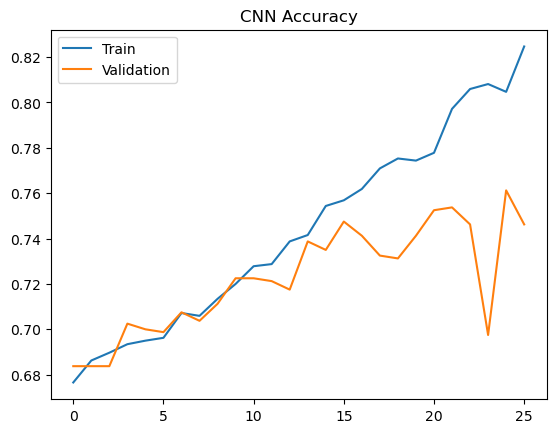

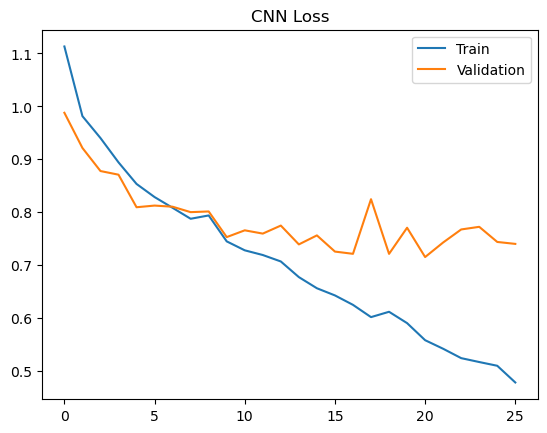

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
import glob
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Cargar datos
# CSV de imágenes
path = r"C:\Users\rammu\Documents\projects\Deeplearning\practica\Deeplearning-\data\hnmist_28_28_RGB.csv"
df = pd.read_csv(path)
print("Columnas del dataset:", df.columns[:10])

# Metadata
metadata = pd.read_csv(r"C:\Users\rammu\Documents\projects\Deeplearning\data\metadata\HAM10000_metadata.csv")

# Etiquetas
y = metadata['dx'].values[:len(df)]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)
num_classes = y_onehot.shape[1]

# Preprocesamiento tabular
tabular_data = metadata[['age', 'sex', 'localization']][:len(df)]
tabular_data = pd.get_dummies(tabular_data, columns=['sex', 'localization'], drop_first=True)
tabular_data['age'] = tabular_data['age'] / tabular_data['age'].max()
tabular_features = tabular_data.values.astype(np.float32)

#  Preprocesamiento imágenes
X_img = df.values.astype(np.float32).reshape(-1, 28, 28, 3)
X_img /= 255.0

X_tab = tabular_features
y_all = y_onehot

#  Convertir labels a one-hot 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_onehot = to_categorical(y_encoded)

# Dividir en train/test  
X_train, X_test, y_train, y_test = train_test_split(
    images, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded)
input_shape = (96, 96, 3)
num_classes = y_train.shape[1]

model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), activation='relu', padding='same', input_shape=input_shape, strides = (1,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size = (3,3), activation='relu', padding='same', input_shape=input_shape, strides = (1,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size = (3,3), activation='relu', padding='same', input_shape=input_shape, strides = (1,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, kernel_size = (3,3), activation='relu', padding='same', input_shape=input_shape, strides = (1,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compilar  
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    "mejor_modelo_early_fusion.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1)
#entrenamos el modelo

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop, checkpoint])
#guardamos el modelo
model.save('cnn_model.h5')
# Evaluación en test
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")
#Graficamos los resultados de accuracy y loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Modelo 2D, conclusiones:
Este ha sido nuestro primer modelo 2D!
Como vemos, la convolución nos ha permitido alcanzar un valor de 0.74 aprox, algo mejor que nuestro modelo tabular. Como ya expliqué en la introducción de este modelo, en el gráfico observamos que el overfitting iba a empezar a suceder a partir de estos valores. por eso, hemos configurado Earlystopping con 'restore_best_weights'=True, de manera que el modelo que tenemos corresponde a la mejor epoch donde el modelo aún aprendía. 


# Modelo 3D: Early Fusion
Ahora, vamos a utilizar la estrategia Early fusion para crear un modelo que combina los datos tabulares (el primer modelo que hicimos) con las imágenes para que el modelo tenga en cuenta además de los datos de imágenes, factores como en qué parte del cuerpo está la lesión, el sexo del paciente y su edad. En este caso, no tendríamos que importar todas las librerías que cargábamos antes, ya que vamos a reutilizar los modelos 1D y 2D 

Columnas del dataset: Index(['pixel0000', 'pixel0001', 'pixel0002', 'pixel0003', 'pixel0004',
       'pixel0005', 'pixel0006', 'pixel0007', 'pixel0008', 'pixel0009'],
      dtype='object')


Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 28, 28,    │        896 │ input_img[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 14, 14,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 14, 14,    │     18,496 │ max_pooling2d_11… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 7, 7, 64)  │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 7, 7, 128) │     73,856 │ max_pooling2d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_tab           │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 3, 3, 128) │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 32)        │        576 │ input_tab[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 1152)      │          0 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 32)        │      1,056 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1184)      │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 1184)      │          0 │ concatenate_1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 7)         │      8,295 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 103,175 (403.03 KB)

 Trainable params: 103,175 (403.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6634 - loss: 1.1159 - val_accuracy: 0.6781 - val_loss: 0.9460
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6829 - loss: 0.9395 - val_accuracy: 0.7130 - val_loss: 0.8292
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7062 - loss: 0.8427 - val_accuracy: 0.7224 - val_loss: 0.7565
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7118 - loss: 0.8081 - val_accuracy: 0.7361 - val_loss: 0.7403
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7248 - loss: 0.7728 - val_accuracy: 0.7424 - val_loss: 0.7196
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7277 - loss: 0.7476 - val_accuracy: 0.7436 - val_loss: 0.7150
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7355 - loss: 0.7249 - val_accuracy: 0.7623 - val_loss: 0.6651
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7388 - loss: 0.6951 - val_accuracy: 0.

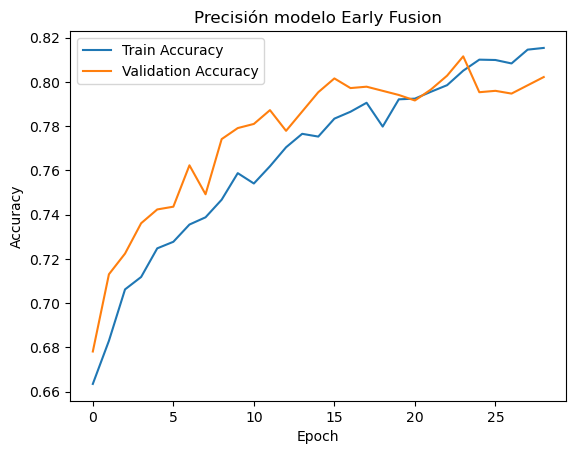

In [38]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


# Cargar datos
# CSV de imágenes
path = r"C:\Users\rammu\Documents\projects\Deeplearning\practica\Deeplearning-\data\hnmist_28_28_RGB.csv"
df = pd.read_csv(path)
print("Columnas del dataset:", df.columns[:10])

# Metadata
metadata = pd.read_csv(r"C:\Users\rammu\Documents\projects\Deeplearning\data\metadata\HAM10000_metadata.csv")

# Etiquetas
y = metadata['dx'].values[:len(df)]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)
num_classes = y_onehot.shape[1]

# Preprocesamiento tabular
tabular_data = metadata[['age', 'sex', 'localization']][:len(df)]
tabular_data = pd.get_dummies(tabular_data, columns=['sex', 'localization'], drop_first=True)
tabular_data['age'] = tabular_data['age'] / tabular_data['age'].max()
tabular_features = tabular_data.values.astype(np.float32)

#  Preprocesamiento imágenes
X_img = df.values.astype(np.float32).reshape(-1, 28, 28, 3)
X_img /= 255.0

X_tab = tabular_features
y_all = y_onehot


# 4 Dividir train/test

X_img_train, X_img_test, X_tab_train, X_tab_test, y_train, y_test = train_test_split(
    X_img, X_tab, y_all, test_size=0.2, random_state=42, stratify=y_encoded
)

# Imputación de NaNs en tabular
X_tab_train = np.where(np.isinf(X_tab_train), np.nan, X_tab_train)
imp = SimpleImputer(strategy='median')
X_tab_train = imp.fit_transform(X_tab_train)
X_tab_test = imp.transform(X_tab_test)


#  Construcción modelo funcional Early Fusion


#  Entrada imágenes 
input_img = Input(shape=(28,28,3), name="input_img")
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)

#Entrada tabular 
input_tab = Input(shape=(X_tab_train.shape[1],), name="input_tab")
y = Dense(32, activation='relu')(input_tab)
y = Dense(32, activation='relu', kernel_regularizer=None)(y)

# Early Fusion 
combined = Concatenate()([x, y])
z = Dropout(0.5)(combined)
output = Dense(num_classes, activation='softmax')(z)

# Modelo final 
early_fusion_model = Model(inputs=[input_img, input_tab], outputs=output)
early_fusion_model.compile(optimizer=Adam(0.001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

early_fusion_model.summary()

# 
# Entrenamiento
# 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = early_fusion_model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop]
)
 
#  Evaluación

test_loss, test_acc = early_fusion_model.evaluate([X_img_test, X_tab_test], y_test)
print(f"Test accuracy: {test_acc:.4f}")

#  graficamos resultados 
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Precisión modelo Early Fusion')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modelo 3: Conclusiones 
En nuestro modelo 3 (Early fusion) Como vemos en la gráfica más arriba, el valor de accuracy ha estado aumentando durante todo el entrenamiento, lo cual nos deja conclusiones muy positivas para este modelo, ya que hemos llegado a alcanzar un 80% (valor más alto hasta ahora)
El modelo aprende de manera estable, y detiene su entrenamiento en epoch 23, el cual sería el punto donde detener el aprendizaje. 
Como vemos, combinar los datos tabulares con los resultados de la CNN ha conseguido que tengamos unas predicciones más fiables. Esto también nos indica que los datos tabualres pueden resultar de ayuda 


Columnas del dataset: Index(['pixel0000', 'pixel0001', 'pixel0002', 'pixel0003', 'pixel0004',
       'pixel0005', 'pixel0006', 'pixel0007', 'pixel0008', 'pixel0009'],
      dtype='object')


c:\Users\rammu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,055 (54.90 KB)

 Trainable params: 13,671 (53.40 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6335 - loss: 2.0850 - val_accuracy: 0.6781 - val_loss: 1.8849
Epoch 2/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6809 - loss: 1.6058 - val_accuracy: 0.6906 - val_loss: 1.4266
Epoch 3/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6862 - loss: 1.3906 - val_accuracy: 0.6943 - val_loss: 1.2252
Epoch 4/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6842 - loss: 1.2476 - val_accuracy: 0.6943 - val_loss: 1.1191
Epoch 5/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6889 - loss: 1.1637 - val_accuracy: 0.7012 - val_loss: 1.0478
Epoch 6/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6861 - loss: 1.1032 - val_accuracy: 0.6968 - val_loss: 1.0218
Epoch 7/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6926 - loss: 1.0627 - val_accuracy: 0.7018 - val_loss: 0.9885
Epoch 8/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6956 - loss: 1.0349 - val_accu

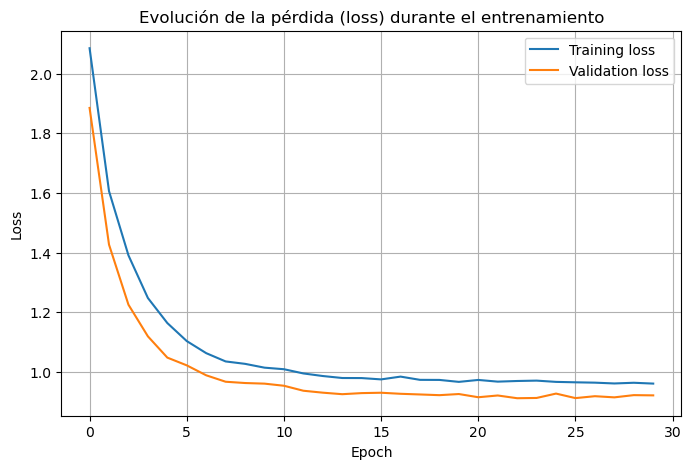

Epoch 1/50


c:\Users\rammu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\rammu\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6619 - loss: 1.0215 - val_accuracy: 0.1067 - val_loss: 2.4744
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6992 - loss: 0.8235 - val_accuracy: 0.1074 - val_loss: 2.0967
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7228 - loss: 0.7677 - val_accuracy: 0.3976 - val_loss: 1.7445
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7273 - loss: 0.7400 - val_accuracy: 0.6679 - val_loss: 1.3893
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7326 - loss: 0.7279 - val_accuracy: 0.5843 - val_loss: 1.0747
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7424 - loss: 0.7040 - val_accuracy: 0.6998 - val_loss: 1.0544
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7502 - loss: 0.6846 - val_accuracy: 0.7322 - val_loss: 0.7432
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7417 - loss: 0.6869 - val_accuracy: 0.714

🔹 Accuracy Late Fusion: 0.7439


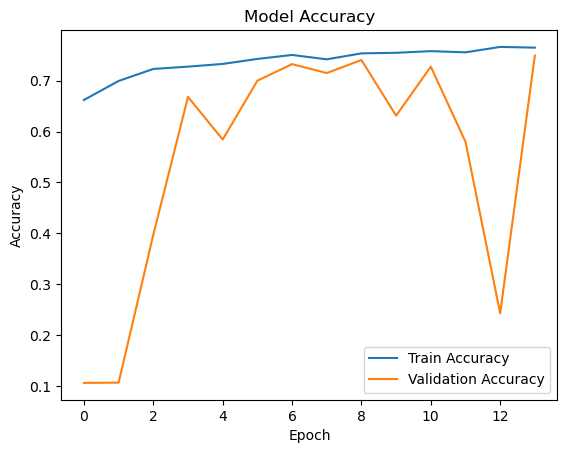

In [39]:
#Por último, vamos a hacer un modelo Late-fusion. En este tipo de modelos, se fusionan datos de distintas categorías 
#Al FINAL del proceso, 
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Concatenate, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Cargamos CSV 
path = r"C:\Users\rammu\Documents\projects\Deeplearning\practica\Deeplearning-\data\hnmist_28_28_RGB.csv"
df = pd.read_csv(path)
print("Columnas del dataset:", df.columns[:10])  # para inspeccionar
# Cargamos metadata
metadata = pd.read_csv(r"C:\Users\rammu\Documents\projects\Deeplearning\data\metadata\HAM10000_metadata.csv")

# Separamos etiquetas desde metadata (por posición, mismo orden que df)
y = metadata['dx'].values[:len(df)]

# codificamos las labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)
num_classes = y_onehot.shape[1]

# Seleccionamos algunas variables numéricas/categóricas (por posición)
tabular_data = metadata[['age', 'sex', 'localization']][:len(df)]

# One-hot encoding para variables categóricas
tabular_data = pd.get_dummies(tabular_data, columns=['sex', 'localization'], drop_first=True)

# Normalización
tabular_data['age'] = tabular_data['age'] / tabular_data['age'].max()

tabular_features = tabular_data.values

# Dividir en train/test
X_img = df.values.astype(np.float32)  # convierte a float32
X_img = X_img.reshape(-1, 28, 28, 3)
X_img /= 255.0 
X_tab = tabular_features.astype(np.float32)
y_train_test = y_onehot

X_img_train, X_img_test, X_tab_train, X_tab_test, y_train, y_test = train_test_split(
    X_img, X_tab, y_train_test, test_size=0.2, random_state=42, stratify=y_encoded
)
#En este punto, hemos hecho un pequeño arreglo que nos ayuda a 
X_tab_train = np.where(np.isinf(X_tab_train), np.nan, X_tab_train)

from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median')
X_tab_train = imp.fit_transform(X_tab_train)
X_tab_test = imp.transform(X_tab_test)

#Modelo tabular
input_tab = Input(shape=(X_tab_train.shape[1],))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

model_tab = Sequential([
    Dense(128, activation='relu', input_shape=(X_tab_train.shape[1],),
          kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])
        # Compilar 
model_tab.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
model_tab.summary()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
        # Entrenamiento
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=7, 
    restore_best_weights=True
)

history_tab = model_tab.fit(
    X_tab_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

#Evaluación 
import matplotlib.pyplot as plt

# Gráfica de pérdida
plt.figure(figsize=(8, 5))
plt.plot(history_tab.history['loss'], label='Training loss')
plt.plot(history_tab.history['val_loss'], label='Validation loss')
plt.title('Evolución de la pérdida (loss) durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Modelo de imágenes
input_shape = (28, 28, 3)
num_classes = y_train.shape[1]

model_img = Sequential()
model_img.add(Conv2D(32, kernel_size = (3,3), activation='relu', padding='same', input_shape=input_shape, strides = (1,1)))
model_img.add(BatchNormalization())
model_img.add(MaxPooling2D(pool_size=(2,2)))
model_img.add(Conv2D(64, kernel_size = (3,3), activation='relu', padding='same', input_shape=input_shape, strides = (1,1)))
model_img.add(BatchNormalization())
model_img.add(MaxPooling2D(pool_size=(2,2)))
model_img.add(Conv2D(128, kernel_size = (3,3), activation='relu', padding='same', input_shape=input_shape, strides = (1,1)))
model_img.add(BatchNormalization())
model_img.add(MaxPooling2D(pool_size=(2,2)))
model_img.add(Conv2D(256, kernel_size = (3,3), activation='relu', padding='same', input_shape=input_shape, strides = (1,1)))
model_img.add(BatchNormalization())
model_img.add(MaxPooling2D(pool_size=(2,2)))
model_img.add(GlobalAveragePooling2D())
model_img.add(Dense(256, activation='relu'))
model_img.add(Dropout(0.5))
model_img.add(Dense(num_classes, activation='softmax'))

        # Compilar 
model_img.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow(X_img_train, y_train, batch_size=64, subset='training')
val_gen = datagen.flow(X_img_train, y_train, batch_size=64, subset='validation')

history_img = model_img.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop]
)
#Evaluación del modelo 

#obtenemos las predicciones de ambos modelos 
pred_img = model_img.predict(X_img_test)
pred_tab = model_tab.predict(X_tab_test)

import numpy as np

# Fusión ponderada por promedio
pred_fusion = (0.6*pred_img + 0.4*pred_tab) 

#evaluamos el modelo combinado
from sklearn.metrics import accuracy_score
import numpy as np

y_pred_classes = np.argmax(pred_fusion, axis=1)
y_true = np.argmax(y_test, axis=1)

acc = accuracy_score(y_true, y_pred_classes)
print(f"🔹 Accuracy Late Fusion: {acc:.4f}")

# guardamos el modelo late fusion
model_img.save('late_fusion_image_model.h5')
model_tab.save('late_fusion_tabular_model.h5')
# Graficamos resultados del modelo de imágenes

import matplotlib.pyplot as plt

plt.plot(history_img.history['accuracy'], label='Train Accuracy')
plt.plot(history_img.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modelo Late fusion: Conclusiones
En este modelo hemos alcanzado un valor de 0.75 aprox. el cual no es malo, pero es peor que en nuestro modelo Early fusion. 
Vemos que esto sucede porque, al procesar las dos modalidades de forma independiente hasta el final, la red no puede aprender interacciones profundas entre modalidades (es decir, yo he configurado que el peso de la parte tabular sea 0.4, y el peso de la parte de imágenes sea 0.6, pero no es una manera muy compleja de hacerlo)
Además, el aprendizaje para clasificar ambas modalidades no se hace de manera conjunta. 
Este tipo de red se utiliza en casos donde se busca la modularidad y la robustez, dado que al no tener interacciones tan complejas entre las dimensiones, es fácil sustituir una variable por otra


# Conclusiones finales:

Hemos terminado nuestro trabajo, creando distintos modelos (1D, 2D, 3D con Early fusion y late fusion, e incluso un modelo que analiza las imágenes en forma de tensor para así conseguir encontrar patrones entre los valores de sus píxeles)
En primer lugar, hemos quitado las variables que no nos valían, y hemos codificado los posibles diagnósticos para que así nuestros modelos puedan trabajar con ellos. 

Como hemos observado, el modelo que peor ha funcionado ha sido el modelo tabular, que nos ha dado valores muy bajos, dado que por ejemplo la edad no debería ser un valor MUY determinante (habrá lesiones que sean más frecuentes según el grupo de edad, y ahí afectarán factores más bien sociológicos,  pero entiendo que todas las lesiones pueden afectar a cualquier grupo de edad)
El modelo que mejores resultados nos ha dado ha sido el Early fusion, llegando a alcanzar valores de 0.78 (aún no muy altos, pero prometedores)

### Posibles mejoras:
- Fine-tuning de modelos preentrenados: Dado que el trabajo consistía en CREAR nuestra propia red, no he valorado esta opción, pero podría ser una buena idea.  Podríamos utilizar redes convolucionales preentrenadas, como ResNet, EfficientNet o VGG, y hacer un ajuste fino con nuestro dataset. Esto permitiría que la red aproveche patrones previamente aprendidos, acelerando el entrenamiento y mejorando la capacidad de generalización.

- Aumento de datos (Data Augmentation): Para el modelo de imágenes, aplicar transformaciones ligeras como rotaciones, traslaciones, zoom o cambios de brillo puede ayudar a reducir el overfitting y enseñar a la red a reconocer lesiones en distintas posiciones o condiciones de iluminación.

- Optimización de la fusión: Para los modelos de Early y Late Fusion, podríamos experimentar con ponderar más las salidas de la imagen frente a los datos tabulares, dado que el modelo tabular mostró menor relevancia. También se podría probar fusionar capas intermedias en lugar de solo al final, para capturar mejor las relaciones entre imágenes y variables tabulares.

- Experimentar distintas tasas de aprendizaje: Ajustar hiperparámetros como el learning rate

- Enriquecer el dataset: Si es posible, aumentar la cantidad de imágenes o incluir datasets externos similares puede mejorar notablemente la capacidad de generalización de los modelos.



